# Assignment 2 - Kobe Bryant Shot EDA Analysis

## Abstract

In the below kernel we have analysed the shots of Kobe Bryant based on the dataset that has been provided for this Kaggle competition and done analysis using H2O <a href="https://github.com/CSYE7245-Spring19/assignment-2-sappers/blob/master/Assignment%202%20-%20H2O.ipynb">(File)</a>
The Kaggle competition link is - https://www.kaggle.com/c/kobe-bryant-shot-selection

And the kernel that we used as a reference to understand the method of plotting and analysis is as below

Link - https://www.kaggle.com/selfishgene/psychology-of-a-professional-athlete

The kernel helps us plot some wonderful graphs of the basketball court and the exact location of Kobe's shot that he made while playing the shot selection.

We use majorly the attributes - `loc_x`, `loc_y`for locating his position on the field and the type of the shot to analyse our plot. At the end we finally get a beautiful analysis on the basis of his ocation and what kind of shot he made from that location as an Exploratory Data Analysis.

EDA - Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.To start with, We imported necessary libraries (for this example pandas, numpy, matplotlib and seaborn) and loaded the dataset.

### Psychology of a Professional Athlete
In this script we explore all shot attempts of Kobe Bryant throughout his career and try to see if Kobe displays the "hot hand" effect

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator

#### Load the data and create some useful fields
show the newly created fields as a sanity check

In [10]:
#%% load training data
allData = pd.read_csv('./data_cleansed.csv')
data = allData[allData['shot_made_flag'].notnull()].reset_index()

#%% add some temporal columns to the data
data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek']    = data['game_date_DT'].dt.dayofweek
data['dayOfYear']    = data['game_date_DT'].dt.dayofyear

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']

# look at first couple of rows and verify that everything is good
data.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,1,10,22,98
1,1,7,45,255
2,1,6,52,308
3,2,6,19,1061
4,3,9,32,1588
5,3,8,52,1628
6,3,6,12,1788
7,3,3,36,1944
8,3,1,56,2044
9,1,11,0,60


#### Plot Shot Attempts as a function of time during the game
here we apply 3 different binnings of time and show the attempts as function from game start

Text(0.5, 0, 'time [seconds from start of game]')

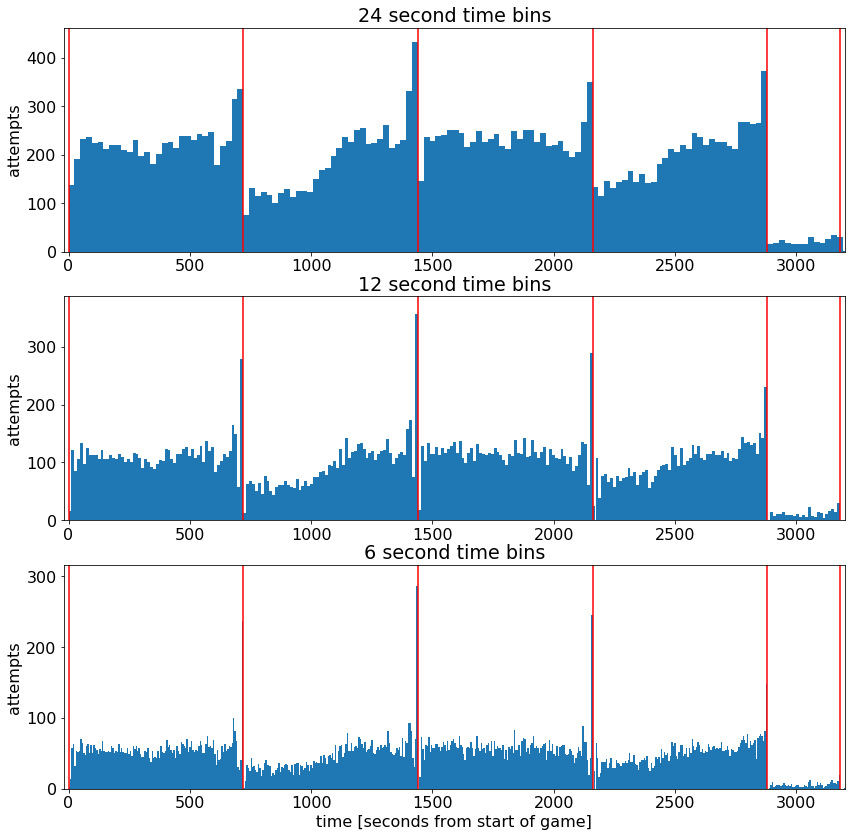

In [11]:
#plot the shot attempts as a function of time (from start of game) with several different binnings
plt.rcParams['figure.figsize'] = (14, 14)
plt.rcParams['font.size'] = 16

binsSizes = [24,12,6]

plt.figure();
for k, binSizeInSeconds in enumerate(binsSizes):
    timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
    attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
    
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(binsSizes),1,k+1); 
    plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); plt.title(str(binSizeInSeconds) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
plt.xlabel('time [seconds from start of game]')

#### It looks like Kobe is entrusted to take the last shot of every period
it also looks like he's usually on the bench at the start of 2nd and 4th periods

### Now let's continue our initial exploration and examine the spatial location aspect of kobe's shots¶
we'll do this by building a gaussian mixture model that tries to summerize Kobe's shot locations compactly

In [12]:
#%% cluster the shot attempts of kobe using GMM on their location
numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(data.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
data['shotLocationCluster'] = gaussianMixtureModel.predict(data.loc[:,['loc_x','loc_y']])

#### Define some helper functions
the function draw_court() is shamelessly stolen from MichaelKrueger's excelent script)

In [13]:
#%% define draw functions (stealing shamelessly the draw_court() function from MichaelKrueger's excelent script)

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        # get the eigen vectors and eigen values of the covariance matrix
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # go to units of standard deviation instead of variance
        
        # calculate the ellipse angle and two axis length and draw it
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

### Draw the 2D Gaussians of Shot Attempts
Each elipse is the countour that represents 2.5 standard deviations away from the center of the gaussian Each number in blue represents the precent of shots taken from this gaussian out of all shots

Text(0.5, 1.0, 'shot attempts')

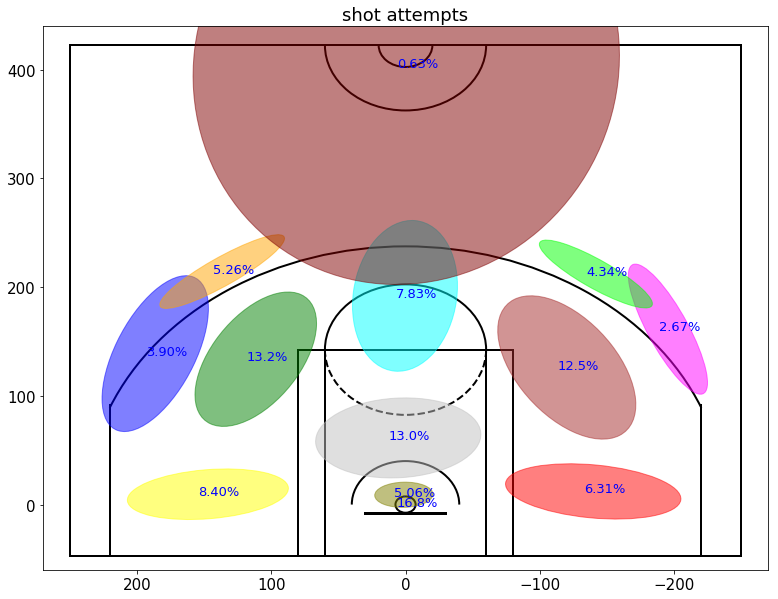

In [14]:
#%% show gaussian mixture elipses of shot attempts
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot attempts')

We can see that Kobe is making more attempts from the left side of the court (or right side from his point of view). this is probably because he's right handed.

Also, we can see that a huge number of attempts (16.8%) is from directly under the basket, and 5.06% additinal attemps are from very close to the basket

### Show the Scatter Plot of all Kobe's shot attempts colored by the cluster assignment according to the GMM
Just to make sure the gaussian model actually captures something

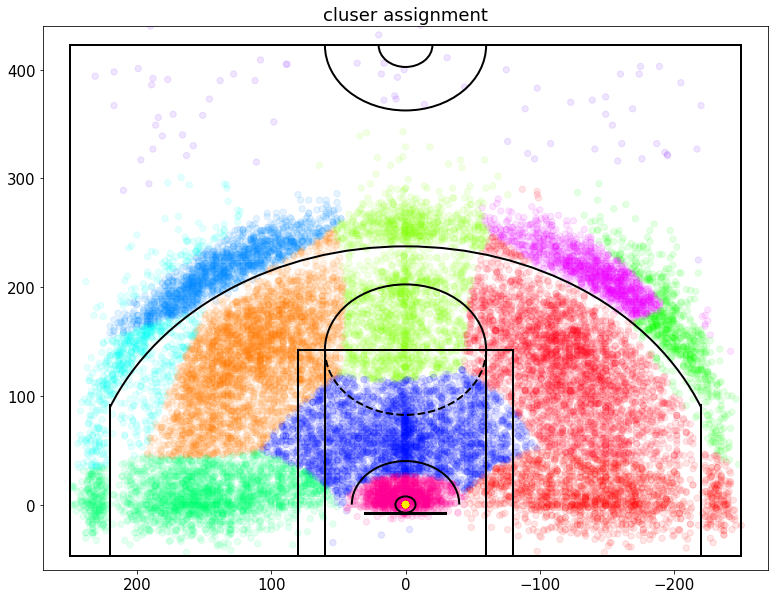

In [15]:
#%% just to make sure the gaussian model actually captures something, show the scatter and cluster assignment
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

plt.figure(); draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('cluser assignment')
plt.scatter(x=data['loc_x'],y=data['loc_y'],c=data['shotLocationCluster'],s=40,cmap='hsv',alpha=0.1)

It doesn't seem perfect, but definatly captures some interesting things about the data for example, we can see that the large and very far away cluster is capturing all of the very distant shots

We can clearly see the dependence between distance and accuracy
Another interesting fact is that Kobe not only makes more attempts from the right side (from his point of view), but also he's better at making those attempts

## Conclusion

We performed the EDA for our analysis on how Kobe performs his shots on the field and what kind of shots are applied at various location depending on the player factor. The EDA helps us to plot the graph on how the location can be used to plot his location of Shot in a beautiful way.

## Citation

* Kaggle competition link - https://www.kaggle.com/c/kobe-bryant-shot-selection
* Kaggle Kernel - https://www.kaggle.com/selfishgene/psychology-of-a-professional-athlete
* Prof. GitHub - https://github.com/nikbearbrown/

## Contribution

* Own -15% in writing the explanation and our own understanding
* Kernel - 85% is from Kernel. We were inquisitive and wanted to refer and use it as a mode of seeing how good this has been performed for study purpose

## License

<font size="4">MIT License</font>
    
<img src="Images/OSI_Approved_License.png" width="100" align="right"/>

<font size="4">
    
<b>Copyright (c) 2019 PRABHU SUBRAMANIAN, PREETAM JAIN</b>

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
